# Notebook to download and plot USBR gage data

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from urllib.request import urlopen
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s: %(message)s', datefmt='%m/%d/%Y %H:%M:%S')

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Station list

![usbr](imgs/usbr_github1.jpg)

![usbr](imgs/usbr_github2.jpg)

## Yakima River

| Station       |  |  |
| ------------- |-------------| ---: |
| EASW | Yakima River at Easton | upstream |
| YUMW | Yakima River at Cle Elum | ↓ |
| YRWW | Yakima River near Horlick | ↓ |
| ELNW | Yakima River near Ellensburg | ↓ |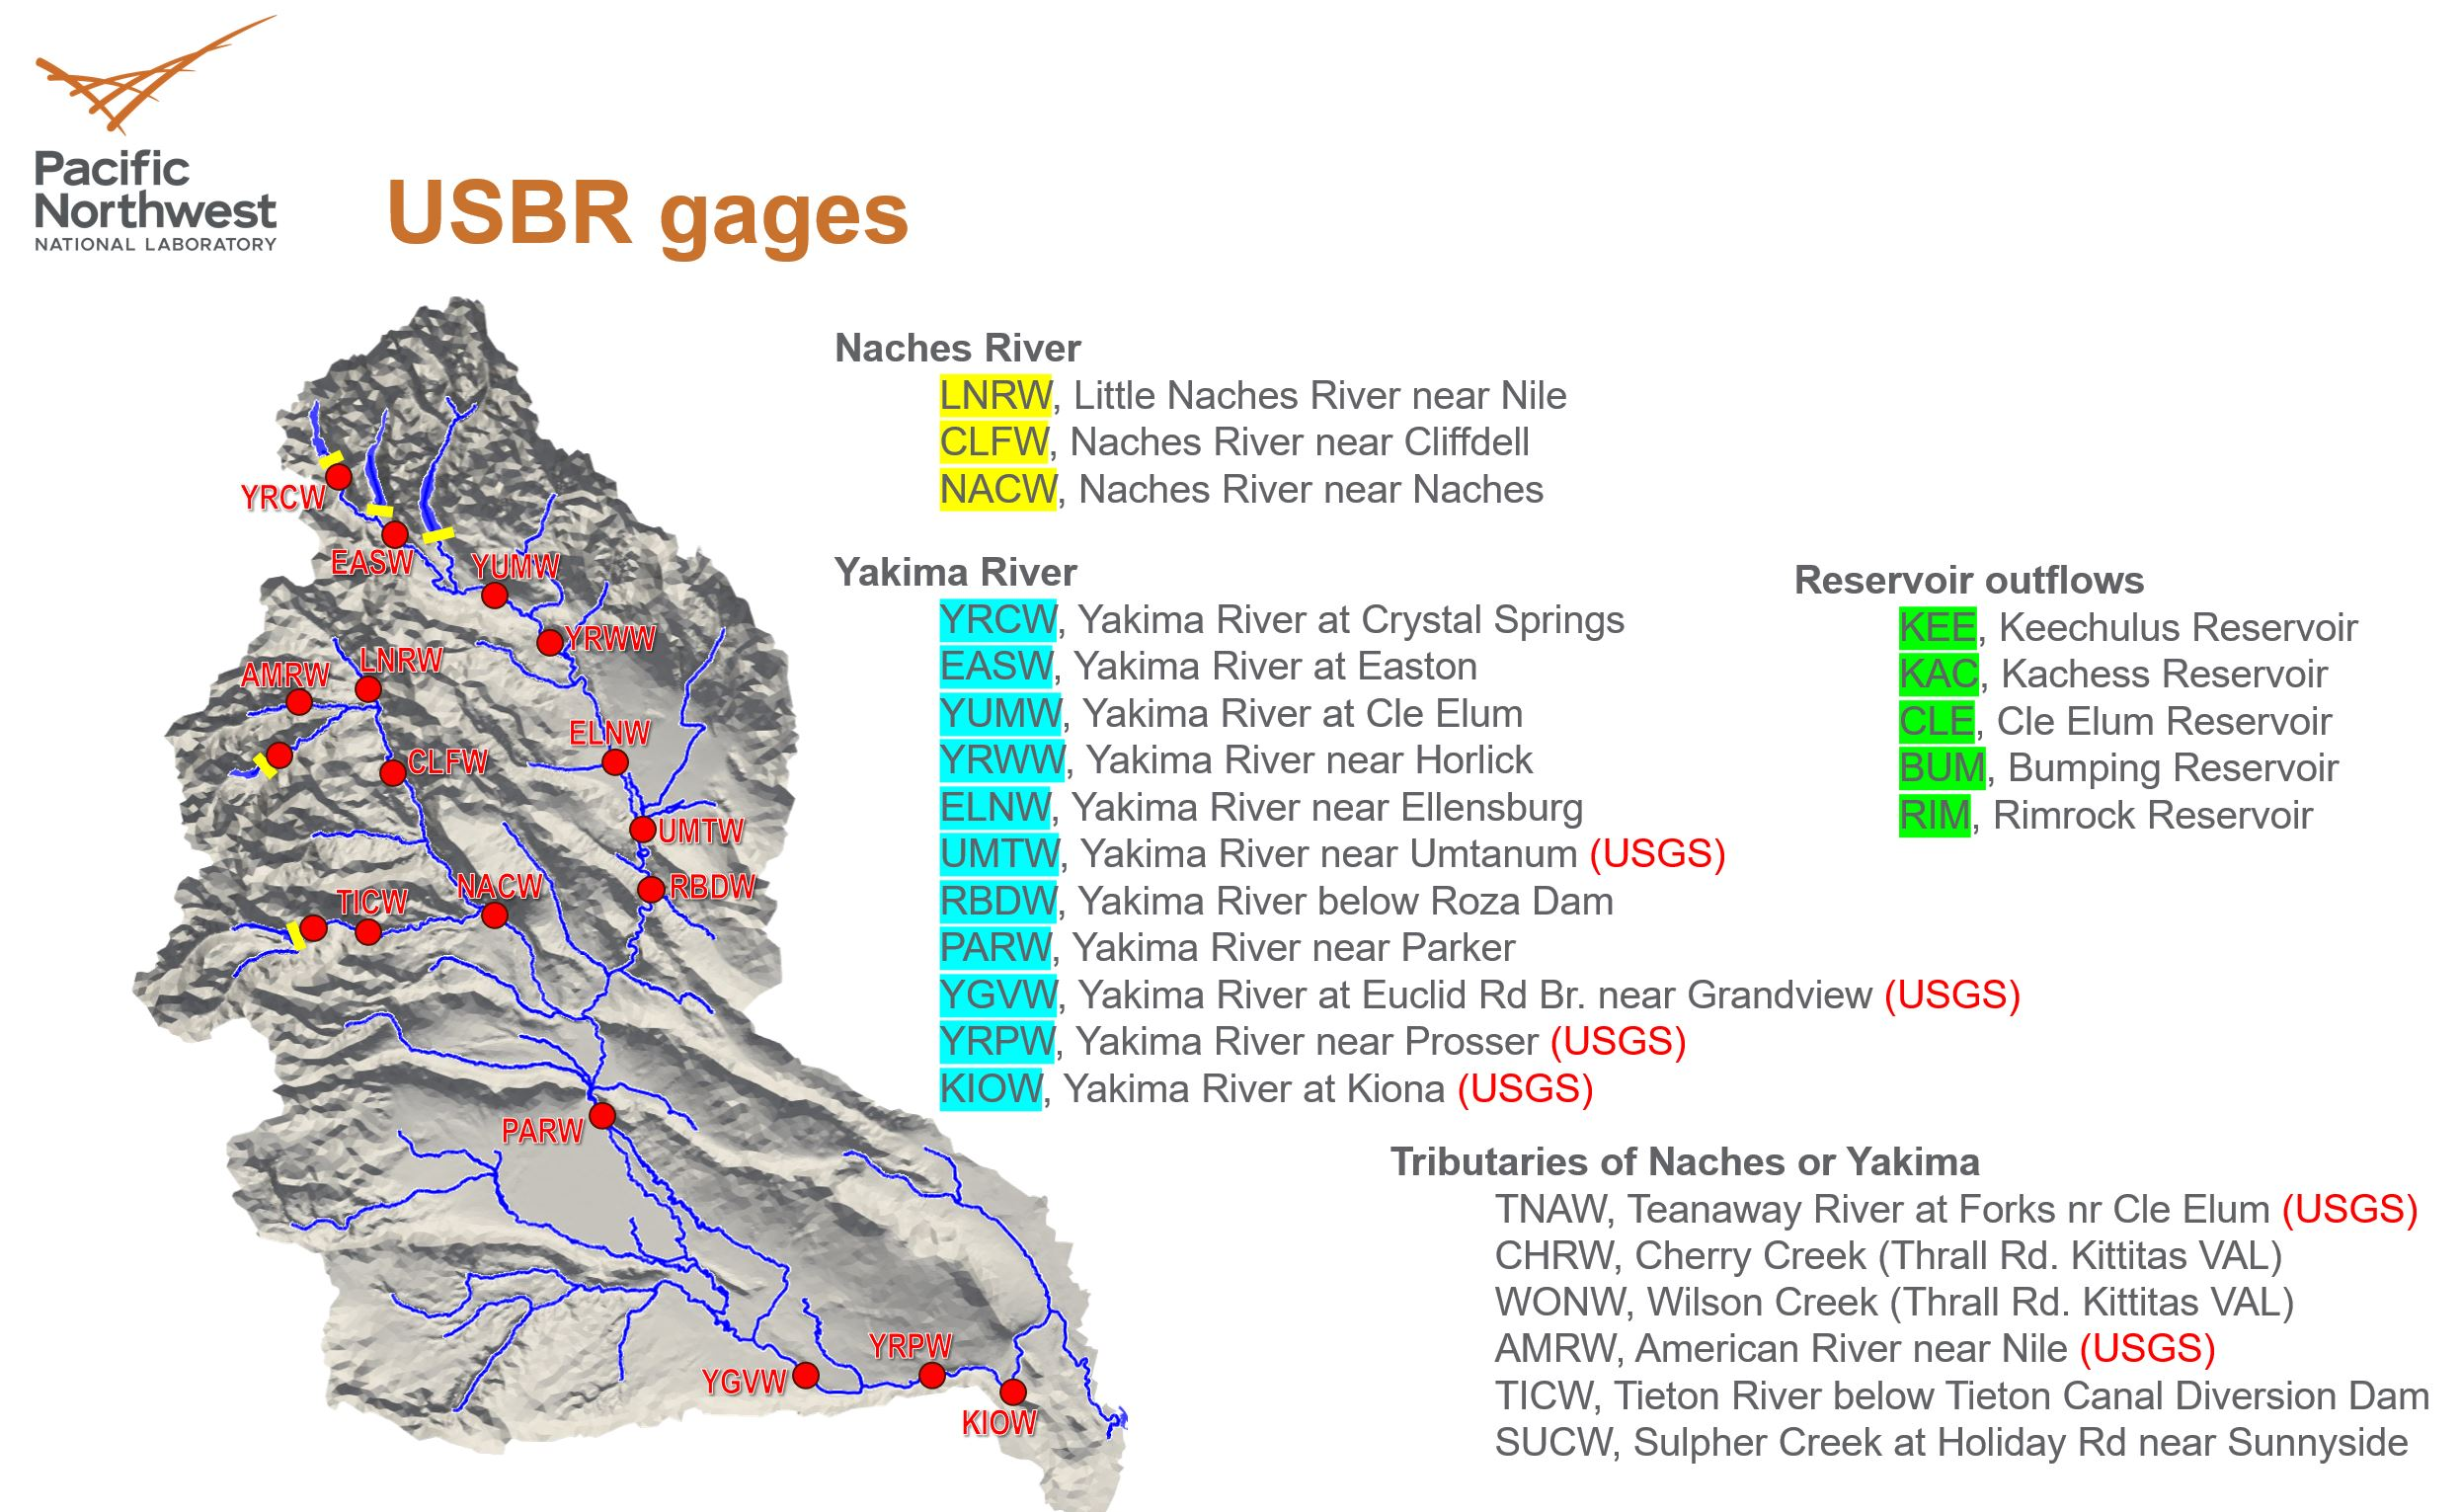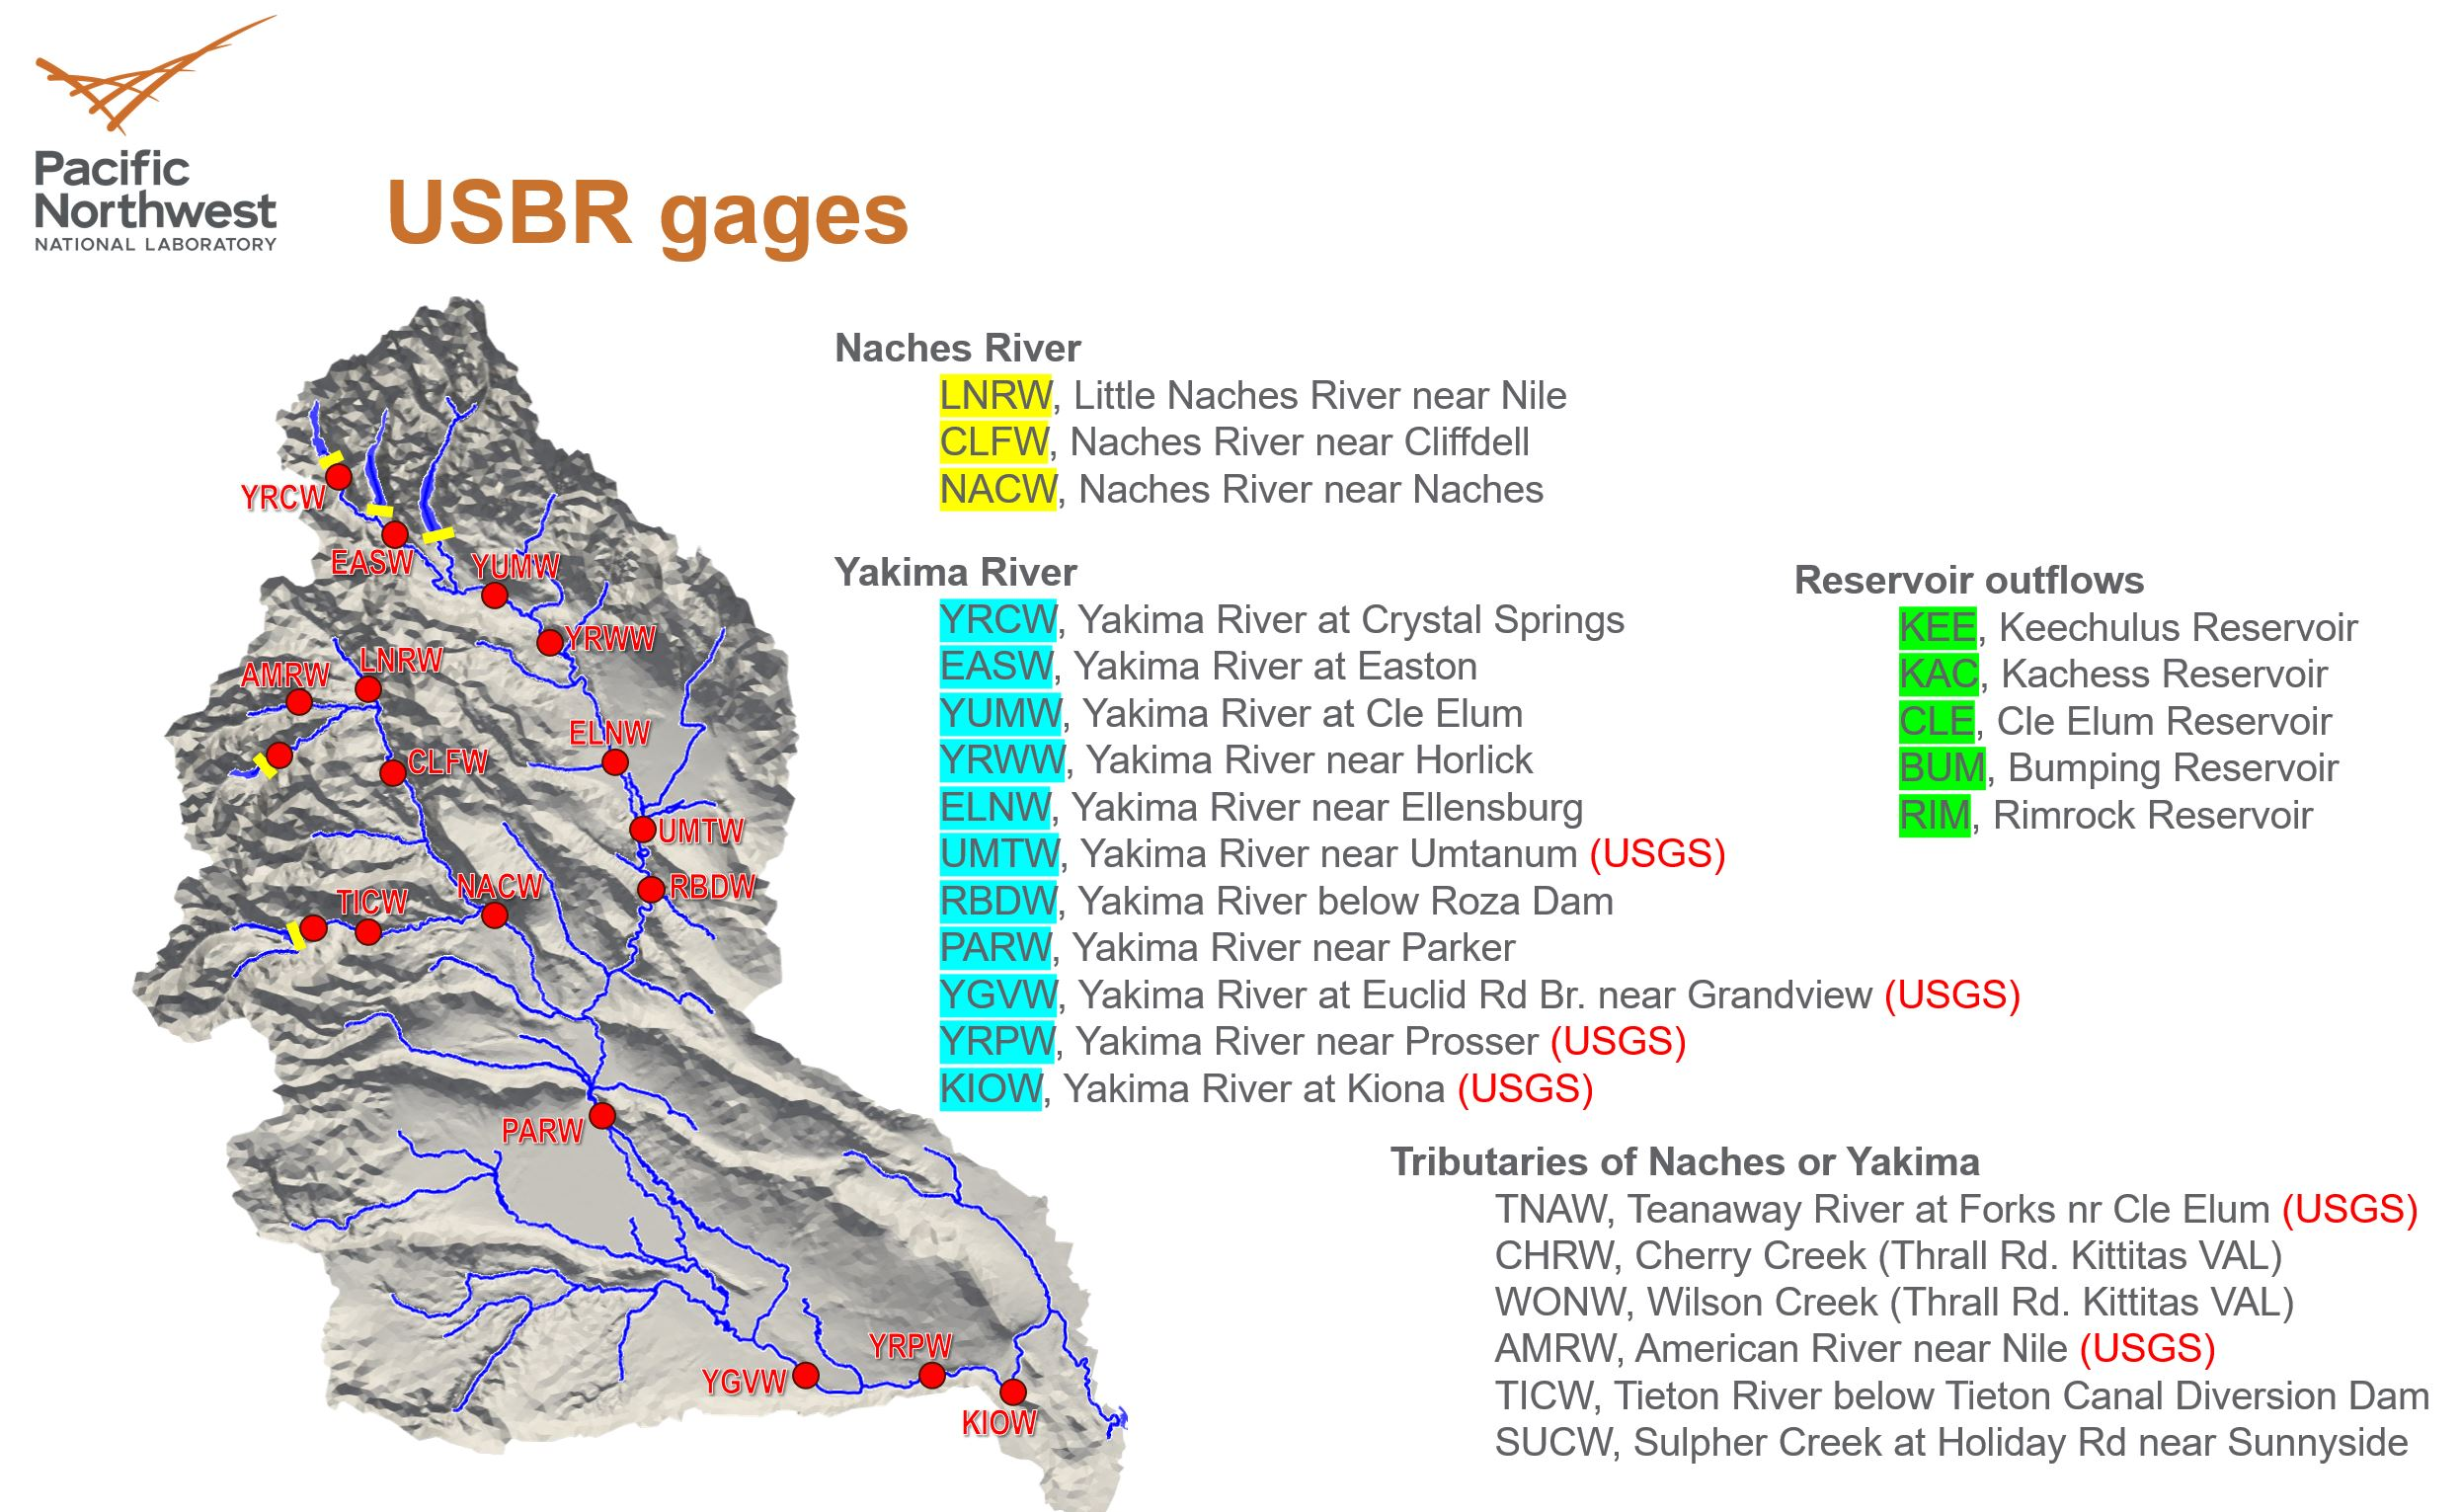
| UMTW | Yakima River near Umtanum | ↓ |
| RBDW | Yakima River below Roza Dam | ↓ |
| PARW | Yakima River near Parker | ↓ |
| YGVW | Yakima River at Euclid Rd Br. near Grandview | ↓ |
| YRPW | Yakima River near Prosser | ↓ |
| KIOW | Yakima River at Kiona | downstream |

## Naches River

| Station       |  |  |
| ------------- |-------------| ---: |
| LNRW | Little Naches River near Nile  | upstream |
| CLFW | Naches River near Cliffdell | ↓ |
| NACW | Naches River near Naches | downstream |

## Reservoir outflows

| Station       |  |  |
| ------------- |-------------| ---: |
| KEE | Keechulus Reservoir  |  |
| KAC | Kachess Reservoir |  |
| CLE | Cle Elum Reservoir |  |
| BUM | Bumping Reservoir |  |
| RIM | Rimrock Reservoir |  |

# Fetch data and write a csv file from a single station

In [2]:
station = 'LNRW'
start = datetime.datetime(1980, 1, 1)
end = datetime.datetime(2024, 10, 1)
logging.info(f'Station {station} from '+start.strftime("%m/%d/%Y")+' to '+end.strftime("%m/%d/%Y"))

10/07/2024 19:50:01 - INFO: Station LNRW from 01/01/1980 to 10/01/2024


In [3]:
dtype = 'daily' # put 'daily' or 'instant'
pcode = 'qd' if dtype == 'daily' else 'q' # use this if it's a river 
# pcode = 'qj' if dtype == 'daily' else 'qc' # use this if it's a canal
logging.info(f'type = {dtype}')
logging.info(f'pcode = {pcode}')

10/07/2024 19:50:01 - INFO: type = daily
10/07/2024 19:50:01 - INFO: pcode = qd


In [4]:
url = f'https://www.usbr.gov/pn-bin/{dtype}.pl?station={station}&format=html&'+\
f'year={start.year}&month={start.month}&day={start.day}&'+\
f'year={end.year}&month={end.month}&day={end.day}&'+\
f'pcode={pcode}&flags=false'
logging.info('URL: '+url)

10/07/2024 19:50:02 - INFO: URL: https://www.usbr.gov/pn-bin/daily.pl?station=LNRW&format=html&year=1980&month=1&day=1&year=2024&month=10&day=1&pcode=qd&flags=false


In [5]:
df = pd.read_html(url)[0] # it's much easier to use pandas.read_html, but seems slower (not sure why); so web scraping used below
df

,DateTime,lnrw_qd
0,1980-01-01,NaN
1,1980-01-02,NaN
2,1980-01-03,NaN
3,1980-01-04,NaN
4,1980-01-05,NaN
...,...,...
16341,2024-09-27,31.89
16342,2024-09-28,29.71
16343,2024-09-29,28.18
16344,2024-09-30,27.95


In [6]:
with urlopen(url) as response:
    html = response.read().decode("utf-8")
logging.info(f'Length of html = {len(html)}')

10/07/2024 19:54:25 - INFO: Length of html = 706628


In [7]:
indx = 1e10
yr = start.strftime("%Y")
while int(indx) > 200:
    for indx in tqdm(range(len(html)-4)):
        if html[indx:indx+4] == yr:
            break
    yr = str(int(yr)+1)

  0%|          | 72/706624 [00:00<00:01, 659366.57it/s]


In [8]:
h = html[indx:].replace('</td><td>', ',').replace('<td>', '').replace('</td>', '').replace('<tr>', '').replace('</tr>', '').replace('</table>\n' ,'')

In [9]:
with open(f'{station}_Q_{dtype}_{start.strftime("%m%d%Y")}_{end.strftime("%m%d%Y")}.csv', 'w') as f:
    f.write(f'DateTime,{station}_Q_{dtype}_cfs\n'+h)

# Fetch data and write csv files from multiple stations

In [10]:
start = datetime.datetime(1980, 1, 1)
end = datetime.datetime(2024, 10, 1)
dtype = 'daily' # put 'daily' or 'instant'
pcode = 'qd' if dtype == 'daily' else 'q' # river 
# pcode = 'qj' if dtype == 'daily' else 'qc' # canal

# stations = ['LNRW', 'CLFW', 'NACW']
stations = ['EASW','YUMW','YRWW','ELNW','UMTW','RBDW','PARW','YGVW','YRPW','KIOW']
# stations = ['KEE', 'KAC', 'CLE', 'BUM', 'RIM']

In [11]:
for station in stations:
    logging.info(f'Station {station} from '+start.strftime("%m/%d/%Y")+' to '+end.strftime("%m/%d/%Y"))
    logging.info(f'type = {dtype}')
    logging.info(f'pcode = {pcode}')
    url = f'https://www.usbr.gov/pn-bin/{dtype}.pl?station={station}&format=html&'+\
    f'year={start.year}&month={start.month}&day={start.day}&'+\
    f'year={end.year}&month={end.month}&day={end.day}&'+\
    f'pcode={pcode}&flags=false'
    logging.info('URL: '+url)
    with urlopen(url) as response:
        html = response.read().decode("utf-8")
    logging.info(f'Length of html = {len(html)}')
    indx = 1e10
    yr = start.strftime("%Y")
    while int(indx) > 200:
        for indx in tqdm(range(len(html)-4)):
            if html[indx:indx+4] == yr:
                break
        yr = str(int(yr)+1)
    h = html[indx:].replace('</td><td>', ',').replace('<td>', '').replace('</td>', '').replace('<tr>', '').replace('</tr>', '').replace('</table>\n' ,'')
    with open(os.path.join(f'{dtype}_data', f'{station}_Q_{dtype}_{start.strftime("%m%d%Y")}_{end.strftime("%m%d%Y")}.csv'), 'w') as f:
        f.write(f'DateTime,{station}_Q_{dtype}_cfs\n'+h)

10/07/2024 19:54:26 - INFO: Station EASW from 01/01/1980 to 10/01/2024
10/07/2024 19:54:26 - INFO: type = daily
10/07/2024 19:54:26 - INFO: pcode = qd
10/07/2024 19:54:26 - INFO: URL: https://www.usbr.gov/pn-bin/daily.pl?station=EASW&format=html&year=1980&month=1&day=1&year=2024&month=10&day=1&pcode=qd&flags=false
10/07/2024 19:56:37 - INFO: Length of html = 720100
  0%|          | 72/720096 [00:00<00:00, 1067102.08it/s]
10/07/2024 19:56:37 - INFO: Station YUMW from 01/01/1980 to 10/01/2024
10/07/2024 19:56:37 - INFO: type = daily
10/07/2024 19:56:37 - INFO: pcode = qd
10/07/2024 19:56:37 - INFO: URL: https://www.usbr.gov/pn-bin/daily.pl?station=YUMW&format=html&year=1980&month=1&day=1&year=2024&month=10&day=1&pcode=qd&flags=false
10/07/2024 19:56:57 - INFO: Length of html = 727814
  0%|          | 72/727810 [00:00<00:00, 996666.30it/s]
10/07/2024 19:56:57 - INFO: Station YRWW from 01/01/1980 to 10/01/2024
10/07/2024 19:56:57 - INFO: type = daily
10/07/2024 19:56:57 - INFO: pcode = qd


# Read csv files and plot

## Naches River

In [12]:
stations = ['LNRW', 'CLFW', 'NACW']

In [13]:
# dtypes = ['instant', 'daily']
dtypes = ['daily']

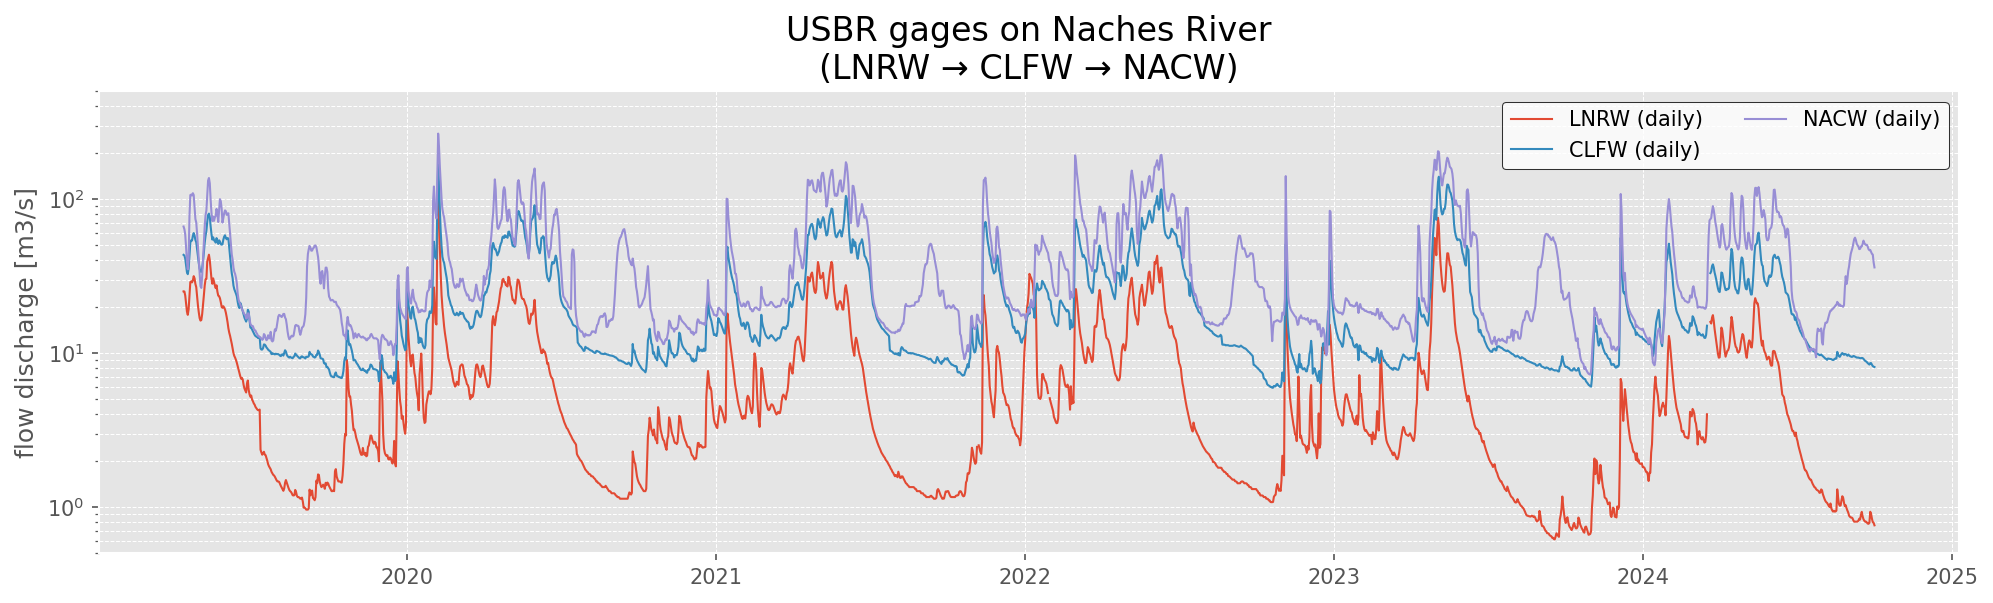

In [14]:
plt.subplots(1, 1, figsize=(16, 4))
for dtype in dtypes:
    alpha = 0.5 if dtype == 'insant' else 1
    lw = 3 if dtype == 'insant' else 1
    for station in stations:
        df = pd.read_csv(os.path.join(f'{dtype}_data', f'{station}_Q_{dtype}_{start.strftime("%m%d%Y")}_{end.strftime("%m%d%Y")}.csv'))
        fct = 24*4 if dtype == 'instant' else 1
        time = pd.to_datetime(df['DateTime'][-2000*fct:])
        flow = df[f'{station}_Q_{dtype}_cfs'][-2000*fct:]*0.3048**3 # cfs to cms
        plt.semilogy(time, flow, label=station+' ('+dtype+')', alpha=alpha, lw=lw)
plt.ylabel('flow discharge [m3/s]')
plt.grid(which='both', ls='--', lw=0.5)
plt.title('USBR gages on Naches River\n(LNRW → CLFW → NACW)', fontsize=16)
plt.legend(facecolor='w', edgecolor='k', ncol=2)
plt.ylim(5e-1, 5e2)
plt.savefig(os.path.join(f'imgs','Naches.jpg'), dpi=300)
plt.show()

## Yakima River

In [15]:
dtypes = ['daily']
stations = ['EASW','YUMW','YRWW','ELNW','UMTW','RBDW','PARW','YGVW','YRPW','KIOW']

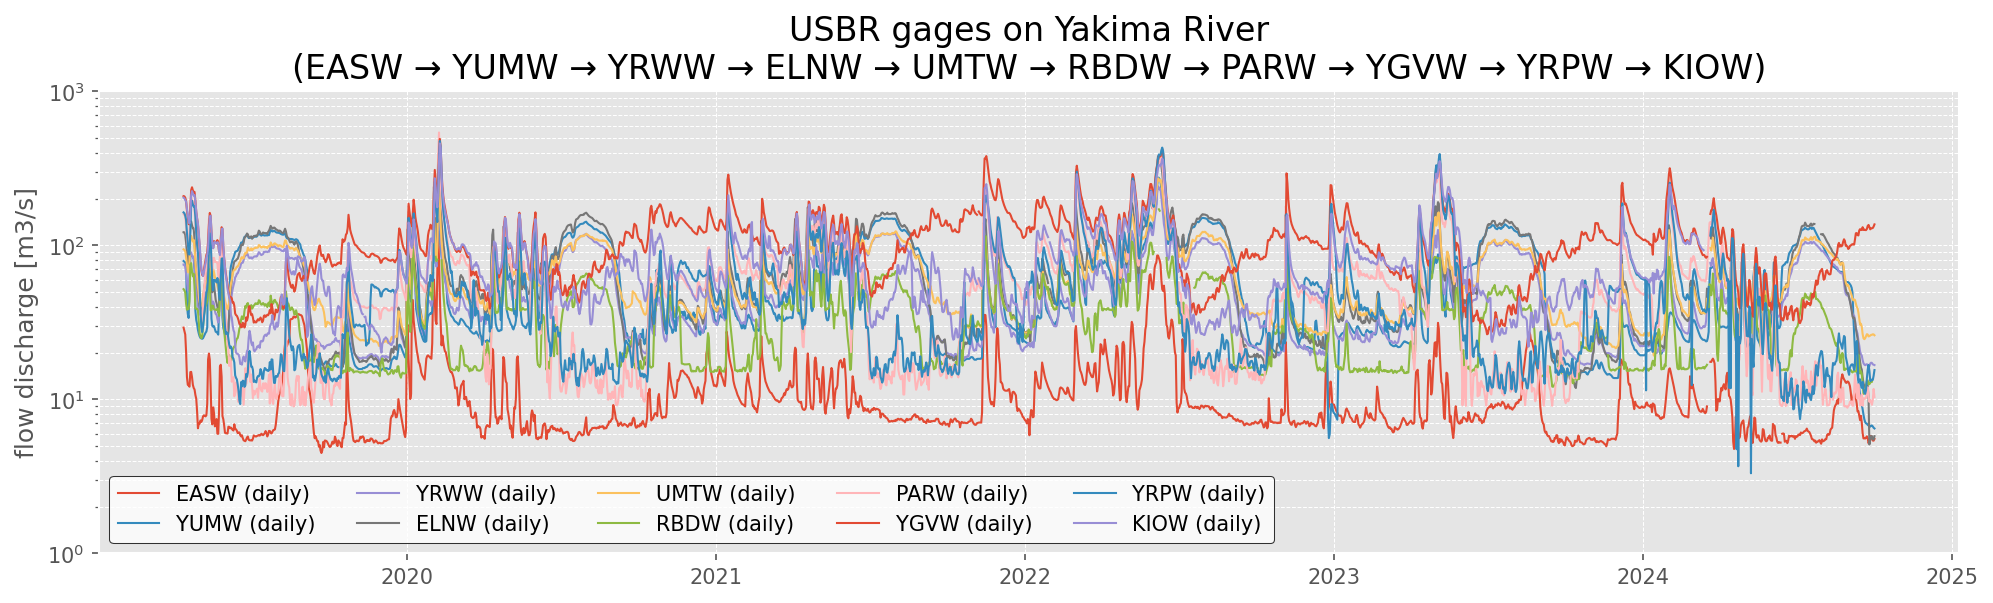

In [17]:
plt.subplots(1, 1, figsize=(16, 4))
for dtype in dtypes:
    alpha = 0.5 if dtype == 'insant' else 1
    lw = 2 if dtype == 'insant' else 1
    for station in stations:
        df = pd.read_csv(os.path.join(f'{dtype}_data', f'{station}_Q_{dtype}_{start.strftime("%m%d%Y")}_{end.strftime("%m%d%Y")}.csv'))
        time = pd.to_datetime(df['DateTime'][-2000:])
        flow = df[f'{station}_Q_{dtype}_cfs'][-2000:]*0.3048**3 # cfs to cms
        plt.semilogy(time, flow, label=station+' ('+dtype+')', alpha=alpha, lw=lw)
plt.ylabel('flow discharge [m3/s]')
plt.grid(which='both', ls='--', lw=0.5)
plt.title('USBR gages on Yakima River\n(EASW → YUMW → YRWW → ELNW → UMTW → RBDW → PARW → YGVW → YRPW → KIOW)', fontsize=16)
plt.legend(facecolor='w', edgecolor='k', ncol=5)
plt.ylim(1, 1e3)
plt.savefig(os.path.join(f'imgs','Yakima.jpg'), dpi=300)
plt.show()

## Reservoir outflows

In [ ]:
# dtypes = ['instant', 'daily']
dtypes = ['instant']
stations = ['KEE', 'KAC', 'CLE', 'BUM', 'RIM']

In [ ]:
plt.subplots(1, 1, figsize=(16, 4))
for dtype in dtypes:
    alpha = 0.5 if dtype == 'insant' else 1
    lw = 2 if dtype == 'insant' else 1
    for station in stations:
        df = pd.read_csv(os.path.join(f'USBR_{dtype}', f'{station}_Q_{dtype}_{start.strftime("%m%d%Y")}_{end.strftime("%m%d%Y")}.csv'))
        fct = 24*4 if dtype == 'instant' else 1
        time = pd.to_datetime(df['DateTime'][-2000*fct:])
        flow = df[f'{station}_Q_{dtype}_cfs'][-2000*fct:]*0.3048**3 # cfs to cms
        plt.semilogy(time, flow, label=station+' ('+dtype+')', alpha=alpha, lw=lw)
plt.ylabel('flow discharge [m3/s]')
plt.grid(which='both', ls='--', lw=0.5)
plt.legend(facecolor='w', edgecolor='k', ncol=5)
plt.ylim(1e-1, 1e3)
plt.show()

In [ ]:
dtypes = ['daily']
stations = ['RIM', 'TIEW', 'TICW', 'NACW']

In [ ]:
plt.subplots(1, 1, figsize=(16, 4))
for dtype in dtypes:
    alpha = 0.5 if dtype == 'insant' else 1
    lw = 2 if dtype == 'insant' else 1
    for station in stations:
        df = pd.read_csv(os.path.join(f'{dtype}_data', f'{station}_Q_{dtype}_{start.strftime("%m%d%Y")}_{end.strftime("%m%d%Y")}.csv'))
        time = pd.to_datetime(df['DateTime'][-3000:])
        flow = df[f'{station}_Q_{dtype}_cfs'][-3000:]*0.3048**3 # cfs to cms
        if station == 'TIEW':
            a = np.copy(flow)
        elif station == 'TICW':
            b = np.copy(flow)
        elif station == 'RIM':
            c = np.copy(flow)
        plt.plot(time, flow, label=station+' ('+dtype+')', alpha=alpha, lw=lw)
plt.ylabel('flow discharge [m3/s]')
plt.grid(which='both', ls='--', lw=0.5)
plt.title('USBR gages on Tieton River \n(RIM = TIEW + TICW)', fontsize=16)
plt.legend(facecolor='w', edgecolor='k', ncol=5)
plt.ylim(-1, 300)
plt.show()

In [ ]:
plt.subplots(1, 1, figsize=(16, 4))
for dtype in dtypes:
    alpha = 0.5 if dtype == 'insant' else 1
    lw = 2 if dtype == 'insant' else 1
    plt.plot(time, a+b, label='TIEW+TICW', alpha=alpha, lw=lw)
    plt.plot(time, c, label='RIM', alpha=alpha, lw=lw)
plt.ylabel('flow discharge [m3/s]')
plt.grid(which='both', ls='--', lw=0.5)
plt.title('USBR gages on Tieton River \n(RIM = TIEW + TICW)', fontsize=16)
plt.legend(facecolor='w', edgecolor='k', ncol=5)
plt.ylim(-1, 300)
plt.show()